## Imports

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import FK5
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import Angle
from astropy import units
from scipy.interpolate import RectBivariateSpline
from scipy import interpolate
import copy
import os
import sys
from tqdm.notebook import tqdm
#from tqdm import tqdm
import glob
import h5py
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = "18"

PATH="/home/ghoshsonia/rfi_RRI/PRATUSH-PRATUSH_sensitivity/sky_models/"

#path_ms1 = '/home/pratush/Documents/saras3/'
#path_ms2 = '/home/pratush/Documents/saras3/utils'
#sys.path.append(path_ms1)
#sys.path.append(path_ms2)

#from ms_fit_joint import *
import scipy.io

## Define paths and constants

In [55]:
CHANNEL_WIDTH       = 0.06103515625/2.0 #/* MHz */
NUMBER_OF_CHANNELS  = 8193
START_FREQUENCY     = 0.00 #/* MHz */

PCHANNEL_WIDTH      = 16.0*0.06103515625 #/* MHz */
PNUMBER_OF_CHANNELS = 41
PSTART_FREQUENCY    = 210.44921875 #/* MHz */

RCHANNEL_WIDTH      = 16.0*0.06103515625 #/* MHz */
RNUMBER_OF_CHANNELS = 103
RSTART_FREQUENCY    = 109.86328125 #/* MHz */

QCHANNEL_WIDTH      = 16.0*0.06103515625 #/* MHz */
QNUMBER_OF_CHANNELS = 72
QSTART_FREQUENCY    = 39.5507812500 #/* MHz */

SITE_LATITUDE       =    -25.2744    #32.81302 #/* +32.77944444   deg for Hanle */ 
SITE_LONGITUDE      =     133.7751#    78.87130 #/* 78.96416667 deg for Hanle */

NHPIX               = 3072
PI                  = 3.14159265358979

TCMB                = 2.72548

filename_coord      = "PIXEL_LISTING_NESTED_R4_GALACTIC.txt" #GMOSS

filename_pix_spec1  ="total_model_spec_13jan17_3072pix_103fq.txt"
filename_pix_spec2  ="total_model_spec_24jan17_1_3072_freq_40_110_MHz_16spacing.txt"
filename_pix_spec3  ="total_model_spec_31jan17_210_250_16spacing.txt"

beam_path  = '/home/ghoshsonia/rfi_RRI/PRATUSH_mayuri/beam_files/elec_small_ant_with_2_12U_bus_cone_scale_0_925_ref_scale_0_9999'
rt_file    = 'gamma_linear.txt'
file_list  = sorted(glob.glob(os.path.join(beam_path,"*mhz.txt")))


##### Fitting constants

fmin = 56.0/1e3
fmax = 109.0/1e3

domain = 'log_log'
LOWF   = fmin*1e3
HGHF   = fmax*1e3
order  = 10

## Define some utility functions

In [3]:
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for val, line in enumerate(data):
            if val==0:
                continue
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))
    return x, y

def Read_pixel_freq(file_name, nfreq):
    with open(file_name, 'r') as data:
        x = np.zeros((NHPIX, nfreq))
        for val, line in enumerate(data):
            if val==0:
                continue
            x[val-1] = [float(i) for i in line.split()]
    return x, np.shape(x)[1]

def select_freq_1d(x1, low, high): 
    prl = 0 
    prh = 0 
    for i in range(0, len(x1)):
        if x1[i]<=low:
            i_low=i+1
            prl = 1 
        if x1[i]>=high:
            i_high=i
            prh = 1 
            break
    if prl==1 and prh==0:
        i_high = len(x1)-1
    if prl==0 and prh==1:
        i_low = 1    
    return i_low, i_high

beam_monopole = lambda theta, phi: np.cos(np.radians(theta))**2 #Maxima at horizon
beam_monopole_sidelobe = lambda theta, phi: 0.025*np.cos(np.radians(theta))**2


## Read Return Loss

In [4]:
gamme_file = os.path.join(beam_path, rt_file)

gamma_freq = []
gamma_val  = []

with open(gamme_file) as fa:
    for line_aa in fa.readlines()[3:]:
        line_aa = line_aa.strip()
        col1    = line_aa.split('\t')
        _freq   = np.array(list(map(float, col1[0].split())))[0]
        _val    = np.array(list(map(float, col1[1].split())))[0]
        gamma_freq.append(_freq)
        gamma_val.append(_val)
        
gamma_freq = np.array(gamma_freq)
gamma_val  = np.array(gamma_val)
    
gamma_func = scipy.interpolate.interp1d(gamma_freq, gamma_val)

## Read, process, and visualize beam files

In [5]:
phi_res   = 1
theta_res = 1

phi_array   = np.arange(0, 360, phi_res)
theta_array = np.arange(-90, 90 + theta_res, theta_res) #because arange does not accept endpoint. Stupid.
freq_array  = []
file_array  = []

def get_freq_from_file(filename):
    _temp = os.path.basename(filename).replace('.txt','').replace('mhz','')
    return float(_temp)
    
for ii, file_add in enumerate(file_list):
    freq_array.append(get_freq_from_file(file_add))
    file_array.append(file_add)
    
np.testing.assert_array_equal(file_array, file_list)

In [7]:
freq_array = np.array(freq_array)
file_array = np.array(file_array)

isort      = np.argsort(freq_array)
freq_array = freq_array[isort]
file_array = file_array[isort]

beam_3D_unnorm = np.zeros((len(freq_array), len(theta_array), len(phi_array)))

for ii, freq in enumerate(freq_array):
    print("Processing frequency {:.1f} MHz".format(freq))
    file_add = file_array[ii]
    with open(file_add) as fa:
        for line_aa in fa.readlines()[2:]:
            line_aa = line_aa.strip()
            col1    = line_aa.split('\t')
            all_val = np.array(list(map(float, col1[0].split())))

            theta   = all_val[0] - 90
            phi     = all_val[1]
            beam    = all_val[2]
            
            iphi    = np.where(phi_array==phi)[0][0]
            itheta  = np.where(theta_array==theta)[0][0]
            beam_3D_unnorm[ii, itheta, iphi] = beam

Processing frequency 55.0 MHz
Processing frequency 57.5 MHz
Processing frequency 60.0 MHz
Processing frequency 62.5 MHz
Processing frequency 65.0 MHz
Processing frequency 67.5 MHz
Processing frequency 70.0 MHz
Processing frequency 72.5 MHz
Processing frequency 75.0 MHz
Processing frequency 77.5 MHz
Processing frequency 80.0 MHz
Processing frequency 82.5 MHz
Processing frequency 85.0 MHz
Processing frequency 87.5 MHz
Processing frequency 90.0 MHz
Processing frequency 92.5 MHz
Processing frequency 95.0 MHz
Processing frequency 97.5 MHz
Processing frequency 100.0 MHz
Processing frequency 102.5 MHz
Processing frequency 105.0 MHz
Processing frequency 107.5 MHz
Processing frequency 110.0 MHz


In [8]:
beam_3D = np.zeros((len(freq_array), len(theta_array), len(phi_array)))
for ifreq in range(beam_3D.shape[0]):
    for iphi in range(beam_3D.shape[2]):
        beam_3D[ifreq,:,iphi] = beam_3D_unnorm[ifreq, :, iphi]/np.amax(beam_3D_unnorm[ifreq, :, iphi])

In [9]:
theta_array_new = theta_array
phi_array_new   = phi_array

In [10]:
from scipy.interpolate import RegularGridInterpolator
my_interpolating_function = RegularGridInterpolator((\
                                                     freq_array, theta_array_new, \
                                                     phi_array_new), beam_3D)

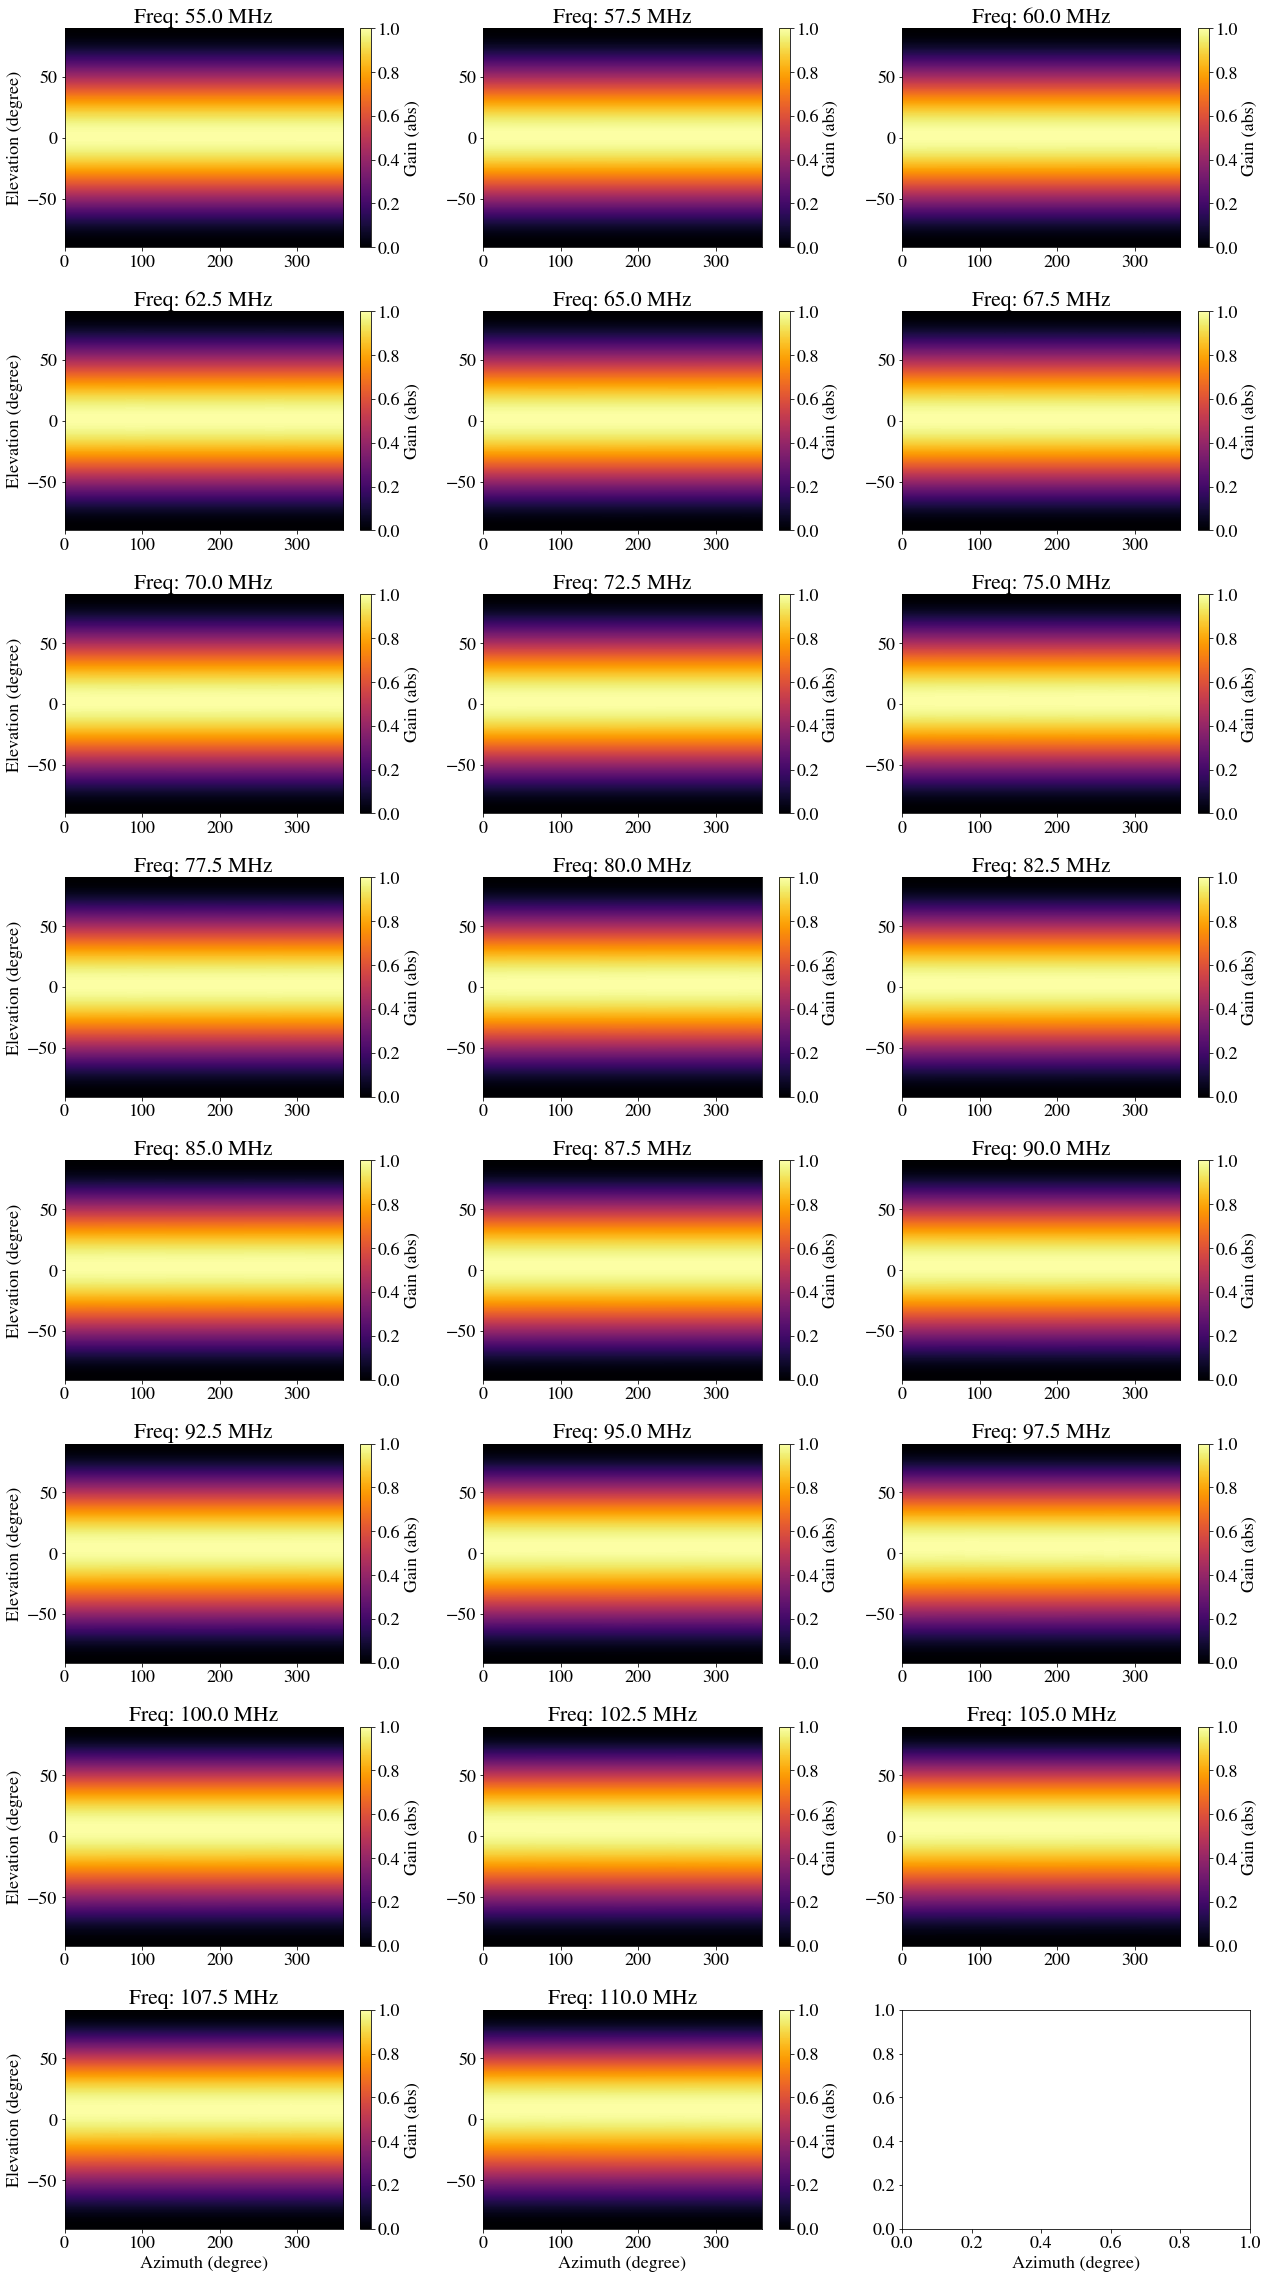

In [11]:
extent = (phi_array[0], phi_array[-1], theta_array[0], theta_array[-1])

nplots = len(freq_array)
ncol   = 3
nrow   = int(np.ceil(nplots/ncol))

fig, _ax = plt.subplots(nrow,ncol,figsize=(6*ncol,4*nrow))
axs      = np.ravel(_ax)

for val, (ax, freq) in enumerate(zip(axs, freq_array)):
    im = ax.imshow(beam_3D[val], aspect='auto', origin='lower', \
                   extent=extent, vmin=0, vmax=1, cmap='inferno')
    fig.colorbar(im, ax=ax, label='Gain (abs)')
    ax.set_title("Freq: {:.1f} MHz".format(freq))

for ax in _ax[:,0]:
    ax.set_ylabel("Elevation (degree)")
for ax in _ax[-1]:
    ax.set_xlabel("Azimuth (degree)")
    
fig.tight_layout()
plt.savefig("beam_plot", dpi=100)
plt.show()

In [12]:
nfreq, ntheta, nphi = beam_3D.shape
ind_phi_0 = np.argmin(np.abs(phi_array))

In [13]:
from matplotlib.transforms import Affine2D
from matplotlib.projections import PolarAxes
from mpl_toolkits.axisartist import angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from mpl_toolkits.axisartist.floating_axes import GridHelperCurveLinear, FloatingSubplot

def fractional_polar_axes(f, thlim=(0, 180), rlim=(0, 1), step=(30, 0.2),
                          thlabel='Elevation angle', rlabel='Normalized response', ticklabels=True):
    """Return polar axes that adhere to desired theta (in deg) and r limits. steps for theta
    and r are really just hints for the locators. Using negative values for rlim causes
    problems for GridHelperCurveLinear for some reason"""
    th0, th1 = thlim # deg
    r0, r1 = rlim
    thstep, rstep = step

    # scale degrees to radians:
    tr_scale = Affine2D().scale(np.pi/180., 1.)
    tr = tr_scale + PolarAxes.PolarTransform()
    theta_grid_locator = angle_helper.LocatorDMS((th1-th0) // thstep)
    r_grid_locator = MaxNLocator((r1-r0) // rstep)
    theta_tick_formatter = angle_helper.FormatterDMS()
    grid_helper = GridHelperCurveLinear(tr,
                                        extremes=(th0, th1, r0, r1),
                                        grid_locator1=theta_grid_locator,
                                        grid_locator2=r_grid_locator,
                                        tick_formatter1=theta_tick_formatter,
                                        tick_formatter2=None)


    a = FloatingSubplot(f, 111, grid_helper=grid_helper)
    f.add_subplot(a)

    # adjust x axis (theta):
    a.axis["bottom"].set_visible(False)
    a.axis["top"].set_axis_direction("bottom") # tick direction
    a.axis["top"].toggle(ticklabels=ticklabels, label=bool(thlabel))
    a.axis["top"].major_ticklabels.set_axis_direction("top")
    a.axis["top"].label.set_axis_direction("top")

    # adjust y axis (r):
    a.axis["left"].set_axis_direction("bottom") # tick direction
    a.axis["right"].set_axis_direction("top") # tick direction
    a.axis["left"].toggle(ticklabels=ticklabels, label=bool(rlabel))

    # add labels:
    a.axis["top"].label.set_text(thlabel)
    a.axis["left"].label.set_text(rlabel)

    # create a parasite axes whose transData is theta, r:
    auxa = a.get_aux_axes(tr)
    # make aux_ax to have a clip path as in a?:
    auxa.patch = a.patch
    # this has a side effect that the patch is drawn twice, and possibly over some other
    # artists. So, we decrease the zorder a bit to prevent this:
    a.patch.zorder = -2

    # add sector lines for both dimensions:
    thticks = grid_helper.grid_info['lon_info'][0]
    rticks = grid_helper.grid_info['lat_info'][0]
    for th in thticks[1:-1]: # all but the first and last
        auxa.plot([th, th], [r0, r1], '--', c='grey', zorder=-1)
    for ri, r in enumerate(rticks):
        # plot first r line as axes border in solid black only if it isn't at r=0
        if ri == 0 and r != 0:
            ls, lw, color = 'solid', 2, 'black'
        else:
            ls, lw, color = 'dashed', 1, 'grey'
        # From http://stackoverflow.com/a/19828753/2020363
        auxa.add_artist(plt.Circle([0, 0], radius=r, ls=ls, lw=lw, color=color, fill=False,
                        transform=auxa.transData._b, zorder=-1))
    return auxa

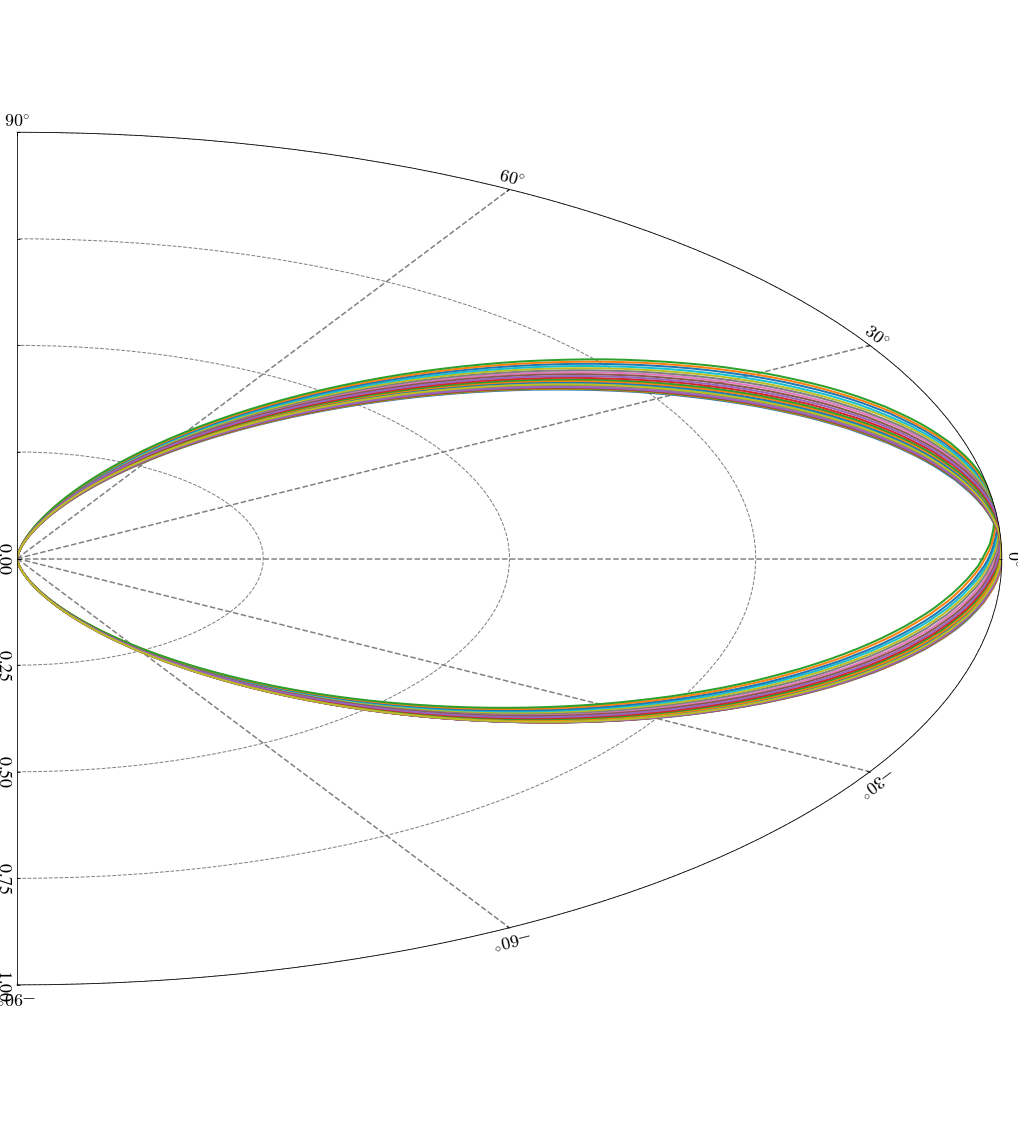

In [49]:
f1     = plt.figure(figsize=(18,16))
a1     = fractional_polar_axes(f1, thlim=(-90,90), rlim=(0,1))
a1.plot(theta_array, beam_3D[:,:,ind_phi_0].T, linewidth=2.0)
plt.tight_layout()
plt.show()

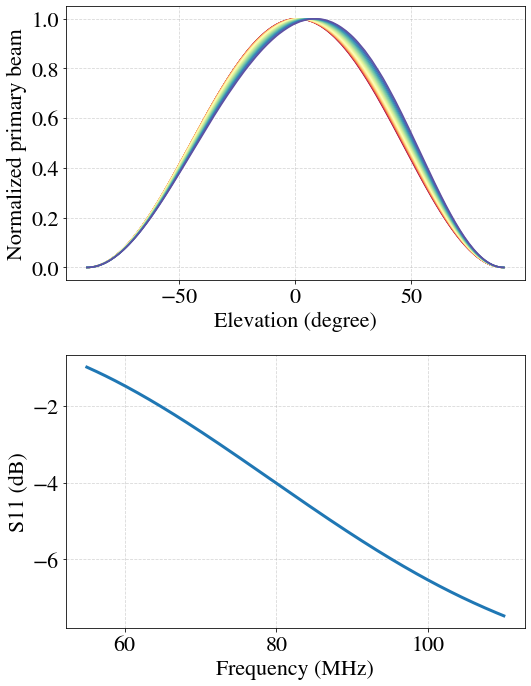

In [14]:
matplotlib.rcParams.update({'font.size': 22})

nrow, ncol = 2, 1
fig, _ax = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

ax = _ax.ravel()

colors = plt.cm.Spectral(np.linspace(0,1,nfreq))

for ii in range(nfreq):
    ax[0].plot(theta_array, beam_3D[ii,:,ind_phi_0], color=colors[ii])
ax[0].set_xlabel("Elevation (degree)")
ax[0].set_ylabel("Normalized primary beam")
ax[0].grid(ls='--', alpha=0.5)

FMIN, FMAX = 55, 110
ind_freq = np.logical_and(gamma_freq>=FMIN, gamma_freq<=FMAX)

ax[1].plot(gamma_freq[ind_freq], 20*np.log10(gamma_val[ind_freq]), lw=3.0)
ax[1].set_xlabel("Frequency (MHz)")
ax[1].set_ylabel("S11 (dB)")
ax[1].grid(ls='--', alpha=0.5)

fig.tight_layout()

#for axx in ax:
    
plt.savefig("PRATUSH_antenna", dpi=100)
plt.show()

In [15]:
for val, (ax, freq) in enumerate(zip(axs, freq_array)):
    im = ax.imshow(beam_3D[val], aspect='auto', origin='lower', \
                   extent=extent, vmin=0, vmax=1, cmap='inferno')

## Read files from GMOSS and 21-cm atlas

In [17]:
ll_coordinate, bb_coordinate = np.radians(Read_Two_Column_File(PATH+filename_coord))

T1, nspec1 = Read_pixel_freq(PATH+filename_pix_spec1, RNUMBER_OF_CHANNELS)
T2, nspec2 = Read_pixel_freq(PATH+filename_pix_spec2, QNUMBER_OF_CHANNELS)
T3, nspec3 = Read_pixel_freq(PATH+filename_pix_spec3, PNUMBER_OF_CHANNELS)

freq    = np.zeros(nspec1+nspec2+nspec3)
T_pix   = np.zeros((NHPIX, nspec1+nspec2+nspec3))

for i in range(0, nspec2):
    freq[i]=(float)(QSTART_FREQUENCY/1000.0) +\
            ((float)(QCHANNEL_WIDTH)/1000.0)*(float)(i)
for i in range(nspec2, (nspec1+nspec2)):
    freq[i]=(float)(RSTART_FREQUENCY/1000.0) + ((float)(RCHANNEL_WIDTH)/1000.0)*(float)(i-nspec2)
for i in range(nspec1+nspec2, (nspec1+nspec2+nspec3)):
    freq[i]=(float)(PSTART_FREQUENCY/1000.0)+((float)(PCHANNEL_WIDTH)/1000.0)*(float)(i-(nspec1+nspec2))

for j in range(0, NHPIX):
    T_pix[j][0:nspec2]=T2[j]
    T_pix[j][(nspec2):(nspec1+nspec2)]=T1[j]
    T_pix[j][(nspec1+nspec2):(nspec1+nspec2+nspec3)]=T3[j]
    
freq_org, T_pix_org = copy.deepcopy(freq), copy.deepcopy(T_pix)

#data21   = scipy.io.loadmat(os.path.join(path_ms1, 'atlas/Data_18March_wMFP.mat'))
#data21   = data21['Data2']/1e3 
#fr       = np.loadtxt(os.path.join(path_ms1,'atlas/freq_saras.txt')) #Frequency in MHz
#signal   = interpolate.interp1d(fr, data21)

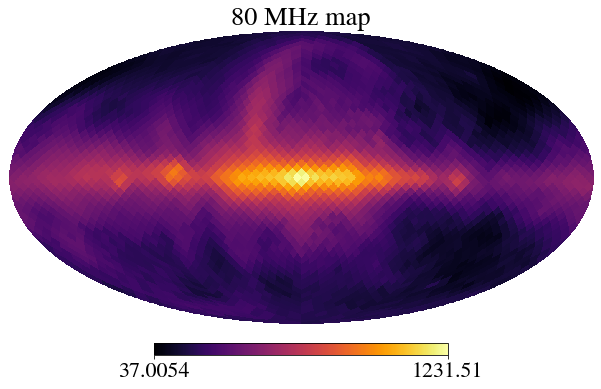

In [18]:
map1 = T_pix_org[:,215]
hp.mollview(map1,title="80 MHz map", norm='log', cmap='inferno', xsize=1400, nest=True)
#np.argmin(np.abs(80-freq_org))

plt.savefig("80_MHz", dpi=200)

## Covolve beam with GMOSS

In [19]:
ifr_low, ifr_hgh = select_freq_1d(freq_org, fmin, fmax)

freq  = freq_org[ifr_low:ifr_hgh]*1e3
T_pix = T_pix_org[:,ifr_low:ifr_hgh]

In [25]:
freq[3]-freq[2]

0.9765625

In [26]:
freq

array([ 56.15234375,  57.12890625,  58.10546875,  59.08203125,
        60.05859375,  61.03515625,  62.01171875,  62.98828125,
        63.96484375,  64.94140625,  65.91796875,  66.89453125,
        67.87109375,  68.84765625,  69.82421875,  70.80078125,
        71.77734375,  72.75390625,  73.73046875,  74.70703125,
        75.68359375,  76.66015625,  77.63671875,  78.61328125,
        79.58984375,  80.56640625,  81.54296875,  82.51953125,
        83.49609375,  84.47265625,  85.44921875,  86.42578125,
        87.40234375,  88.37890625,  89.35546875,  90.33203125,
        91.30859375,  92.28515625,  93.26171875,  94.23828125,
        95.21484375,  96.19140625,  97.16796875,  98.14453125,
        99.12109375, 100.09765625, 101.07421875, 102.05078125,
       103.02734375, 104.00390625, 104.98046875, 105.95703125,
       106.93359375, 107.91015625, 108.88671875])

In [16]:
np.shape(T_pix)

(3072, 55)

In [52]:
#dt = TimeDelta(np.arange(0.,24.*3600,10000000), format='sec')
#dt = TimeDelta(np.linspace(0.,24.*3600, 3), format='sec') #Will take ~5 min

dt = TimeDelta(np.linspace(0.,24.*3600, 500), format='sec') #Will take ~5 min

obstimes = Time('2019-4-12 23:00:00') + dt

In [56]:
hanle = EarthLocation(lat=SITE_LATITUDE*u.deg, lon=SITE_LONGITUDE*u.deg, height=4500*u.m)
gc    = SkyCoord(l=ll_coordinate*u.radian, b=bb_coordinate*u.radian,\
        frame='galactic')

T_bws          = np.zeros((obstimes.shape[0], freq.shape[0]))
#T_bws_monopole = np.zeros((obstimes.shape[0], freq.shape[0]))
T_monopole = np.zeros((obstimes.shape[0], freq.shape[0]))


#Get RA, DEC 
trans      = gc.transform_to('icrs')
ra, dec    = trans.ra.hour, trans.dec.hour

observing_time = Time(obstimes, scale='utc', location=hanle)
LST            = observing_time.sidereal_time('mean').value

In [57]:
T_bws_monopole_aus= np.zeros((obstimes.shape[0], freq.shape[0]))

In [22]:
%store -r elev_ang
%store -r power_output
np.shape(power_output[0,:,:])

(3072, 55)

In [58]:
for val, (time,i) in enumerate(zip(obstimes, tqdm(range(len(obstimes))))):
    
    print("Processing time: {}".format(time))
   
    #Get Alt, Az
    
    trans_local                 = gc.transform_to(AltAz(obstime=time, location=hanle))
    az, alt                     = trans_local.az.degree, trans_local.alt.degree
    
    #ind_below_horizon           = alt < 0
       
    ############################
    
#    beam_gen = np.zeros_like(T_pix)
    
#     for ifreq, freq_value in enumerate(freq):
#         rogue_phi  = []
#         for iangle, (alt_value, az_value) in enumerate(zip(alt, az)):
            
#             if az_value > phi_array_new.max():
#                 rogue_phi.append(az_value)
#                 az_value = 360 - az_value
                
#             beam_gen[iangle,ifreq] = my_interpolating_function([freq_value, alt_value, az_value])
            
#     beam_gen[ind_below_horizon,:] = np.nan
#     T_bws[val]                    = np.nansum(T_pix * beam_gen, axis=0)/np.nansum(beam_gen, axis=0)
    
    #############################
    
    beam_gen_monopole                    = beam_monopole(alt, az)
    beam_rfi=beam_monopole_sidelobe(elev_ang[:,2167,:], az)
    #beam_gen_monopole[ind_below_horizon] = np.nan
   # T_bws_monopole[val]                  = np.nansum(T_pix * beam_gen_monopole[:,None],axis=0)\
                                         #  /np.nansum(beam_gen_monopole)
    T_bws_monopole_aus[val]                  = np.nansum(T_pix * beam_gen_monopole[:,None],axis=0)\
                                               /np.nansum(beam_gen_monopole)
    T_monopole[val]                  = np.nansum(T_pix * beam_gen_monopole[:,None] + power_output[0,:,:]*beam_rfi.T,axis=0)\
                                            /np.nansum(beam_gen_monopole+beam_rfi)
    
    #############################

  0%|          | 0/500 [00:00<?, ?it/s]

Processing time: 2019-04-12 23:00:00.000
Processing time: 2019-04-12 23:02:53.146
Processing time: 2019-04-12 23:05:46.293
Processing time: 2019-04-12 23:08:39.439
Processing time: 2019-04-12 23:11:32.585
Processing time: 2019-04-12 23:14:25.731
Processing time: 2019-04-12 23:17:18.878
Processing time: 2019-04-12 23:20:12.024
Processing time: 2019-04-12 23:23:05.170
Processing time: 2019-04-12 23:25:58.317
Processing time: 2019-04-12 23:28:51.463
Processing time: 2019-04-12 23:31:44.609
Processing time: 2019-04-12 23:34:37.756
Processing time: 2019-04-12 23:37:30.902
Processing time: 2019-04-12 23:40:24.048
Processing time: 2019-04-12 23:43:17.194
Processing time: 2019-04-12 23:46:10.341
Processing time: 2019-04-12 23:49:03.487
Processing time: 2019-04-12 23:51:56.633
Processing time: 2019-04-12 23:54:49.780
Processing time: 2019-04-12 23:57:42.926
Processing time: 2019-04-13 00:00:36.072
Processing time: 2019-04-13 00:03:29.218
Processing time: 2019-04-13 00:06:22.365
Processing time:

Processing time: 2019-04-13 08:45:48.697
Processing time: 2019-04-13 08:48:41.844
Processing time: 2019-04-13 08:51:34.990
Processing time: 2019-04-13 08:54:28.136
Processing time: 2019-04-13 08:57:21.283
Processing time: 2019-04-13 09:00:14.429
Processing time: 2019-04-13 09:03:07.575
Processing time: 2019-04-13 09:06:00.721
Processing time: 2019-04-13 09:08:53.868
Processing time: 2019-04-13 09:11:47.014
Processing time: 2019-04-13 09:14:40.160
Processing time: 2019-04-13 09:17:33.307
Processing time: 2019-04-13 09:20:26.453
Processing time: 2019-04-13 09:23:19.599
Processing time: 2019-04-13 09:26:12.745
Processing time: 2019-04-13 09:29:05.892
Processing time: 2019-04-13 09:31:59.038
Processing time: 2019-04-13 09:34:52.184
Processing time: 2019-04-13 09:37:45.331
Processing time: 2019-04-13 09:40:38.477
Processing time: 2019-04-13 09:43:31.623
Processing time: 2019-04-13 09:46:24.770
Processing time: 2019-04-13 09:49:17.916
Processing time: 2019-04-13 09:52:11.062
Processing time:

Processing time: 2019-04-13 18:22:57.956
Processing time: 2019-04-13 18:25:51.102
Processing time: 2019-04-13 18:28:44.248
Processing time: 2019-04-13 18:31:37.395
Processing time: 2019-04-13 18:34:30.541
Processing time: 2019-04-13 18:37:23.687
Processing time: 2019-04-13 18:40:16.834
Processing time: 2019-04-13 18:43:09.980
Processing time: 2019-04-13 18:46:03.126
Processing time: 2019-04-13 18:48:56.273
Processing time: 2019-04-13 18:51:49.419
Processing time: 2019-04-13 18:54:42.565
Processing time: 2019-04-13 18:57:35.711
Processing time: 2019-04-13 19:00:28.858
Processing time: 2019-04-13 19:03:22.004
Processing time: 2019-04-13 19:06:15.150
Processing time: 2019-04-13 19:09:08.297
Processing time: 2019-04-13 19:12:01.443
Processing time: 2019-04-13 19:14:54.589
Processing time: 2019-04-13 19:17:47.735
Processing time: 2019-04-13 19:20:40.882
Processing time: 2019-04-13 19:23:34.028
Processing time: 2019-04-13 19:26:27.174
Processing time: 2019-04-13 19:29:20.321
Processing time:

In [69]:
beam_rfi=beam_monopole(elev_ang[:,686,:], az)
beam_rfi

array([[0.07437205, 0.07646751, 0.08702538, ..., 0.28571651, 0.29973002,
        0.29689346]])

In [65]:
T_bws_monopole_aus[250]

array([4594.59589251, 4404.79343171, 4225.73532135, 4056.65461364,
       3896.84974922, 3745.67853185, 3602.55179812, 3466.92909813,
       3338.31348215, 3216.24719629, 3100.30910284, 2990.10991783,
       2885.2905944 , 2785.5189569 , 2690.48737402, 2599.91084414,
       2513.52515345, 2431.08473442, 2352.3615241 , 2277.14320512,
       2205.23211654, 2136.4441141 , 2070.60729482, 2007.56112999,
       1947.15588029, 1889.25122957, 1833.71582785, 1780.42686287,
       1729.26904872, 1680.13425606, 1632.92110453, 1587.534259  ,
       1543.88392887, 1501.88585467, 1461.46083274, 1422.53384454,
       1385.03463696, 1348.89651964, 1314.05696763, 1280.4566018 ,
       1248.03942842, 1216.75265989, 1186.5461891 , 1157.37257472,
       1129.18706302, 1101.94703522, 1075.61223511, 1050.14436859,
       1025.50734563, 1001.66659358,  978.58943716,  956.24475194,
        934.60307327,  913.63625688,  893.31749681])

In [64]:
T_bws_monopole[250]

array([3688.99879468, 3536.13947481, 3391.971748  , 3255.87196156,
       3127.26996462, 3005.64411646, 2890.51612393, 2781.44740879,
       2678.03486671, 2579.90741531, 2486.72369951, 2398.16841688,
       2313.95077812, 2233.80189996, 2157.47286076, 2084.73312094,
       2015.36900654, 1949.18201563, 1885.98783464, 1825.61493553,
       1767.90367232, 1712.70535518, 1659.88121611, 1609.30171262,
       1560.84601106, 1514.4009387 , 1469.86058269, 1427.12590644,
       1386.10398473, 1346.70768159, 1308.85529597, 1272.4700227 ,
       1237.47956262, 1203.81605477, 1171.41571249, 1140.21817174,
       1110.16686137, 1081.20814334, 1053.29168574, 1026.36973363,
       1000.39725312,  975.33177378,  951.13301205,  927.76283145,
        905.1852442 ,  883.36600345,  862.27275452,  841.87473392,
        822.14292112,  803.04956057,  784.56839736,  766.67444036,
        749.3440149 ,  732.55452638,  716.2844576 ])

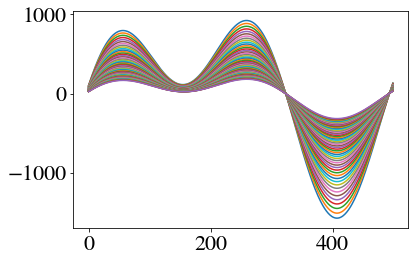

In [62]:
diff=T_bws_monopole_aus-T_bws_monopole
plt.plot(diff)
plt.show()

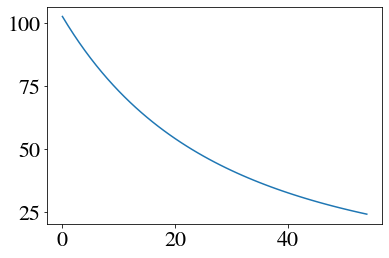

In [63]:
diff1=T_bws_monopole_aus[0]-T_bws_monopole[0]
plt.plot(diff1)
plt.show()

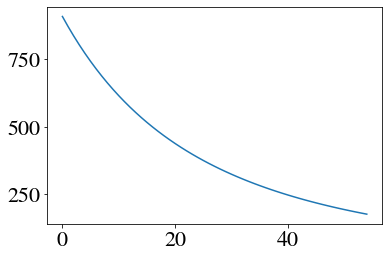

In [68]:
diff2=T_bws_monopole_aus[250]-T_bws_monopole[250]
plt.plot(diff2)
plt.show()

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITHOUT RFI ')

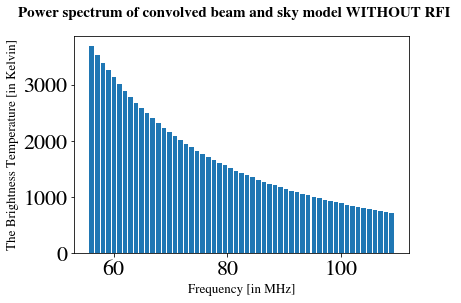

In [69]:

plt.bar(freq,T_bws_monopole[250]) 
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITHOUT RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITHOUT RFI ')

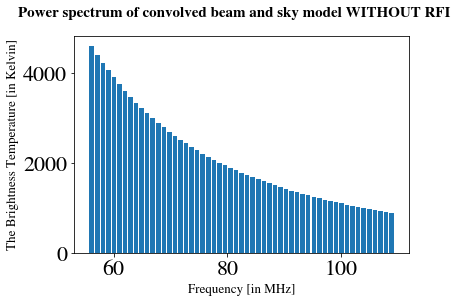

In [70]:
plt.bar(freq,T_bws_monopole_aus[250]) 
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITHOUT RFI ',fontsize=15, fontweight="bold")

Text(0.5, 0.98, 'Power spectrum of convolved beam and sky model WITH RFI ')

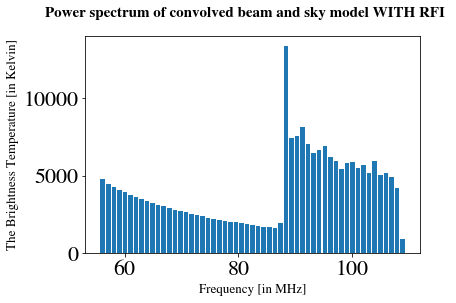

In [25]:
plt.bar(freq,T_monopole[0]) 
#plt.ylim(0, 10000)
plt.xlabel('Frequency [in MHz]',fontsize=13)
plt.ylabel('The Brightness Temperature [in Kelvin]',fontsize=13)
plt.suptitle('Power spectrum of convolved beam and sky model WITH RFI ',fontsize=15, fontweight="bold")

<BarContainer object of 55 artists>

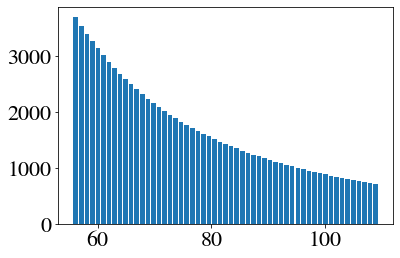

In [148]:
plt.bar(freq,T_bws_monopole[250]) 

(0.0, 15000.0)

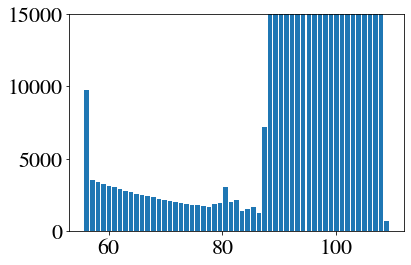

In [149]:
plt.bar(freq,T_monopole[250]) 
plt.ylim(0, 15000)

<BarContainer object of 55 artists>

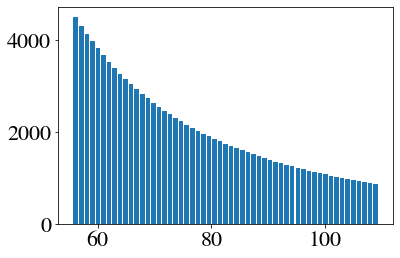

In [150]:
plt.bar(freq,T_bws_monopole[499]) 

(0.0, 15000.0)

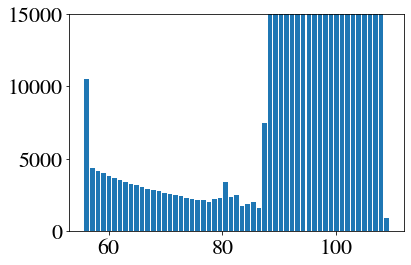

In [156]:
plt.bar(freq,T_monopole[499]) 
plt.ylim(0, 15000)

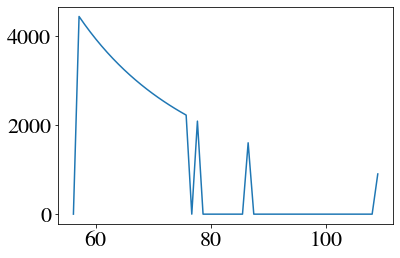

In [126]:
plt.plot(freq,T_monopole[480]) 


In [125]:

T_monopole[480]=np.where(T_monopole[480]>5000, np.nan, T_monopole[480])

In [102]:
beam_rfi=beam_monopole(elev_ang[:,686,:], az)

In [38]:
np.shape(beam_rfi)

(1, 3072)

In [147]:
power_output[0,:,:] #HANLE_36000_COS^2 THETA

array([[0, 0, 0, ..., 117015814.96996173, 102706475.0297322, 0],
       [0, 0, 0, ..., 117015814.96996173, 102706475.0297322, 0],
       [0, 0, 0, ..., 117015814.96996173, 102706475.0297322, 0],
       ...,
       [9817216.833535127, 0, 0, ..., 46039485.2868879,
        24268334.22370555, 0],
       [9817216.833535127, 0, 0, ..., 46039485.2868879,
        24268334.22370555, 0],
       [9817216.833535127, 0, 0, ..., 46038794.542674094,
        24266984.214945506, 0]], dtype=object)

In [146]:
power_output[0,:,:]*beam_rfi.T #HANLE_36000_COS^2 THETA

array([[0.0, 0.0, 0.0, ..., 45156.73410454352, 39634.71933193914, 0.0],
       [0.0, 0.0, 0.0, ..., 46527.620630852194, 40837.966284661394, 0.0],
       [0.0, 0.0, 0.0, ..., 53524.293204436945, 46979.04710484422, 0.0],
       ...,
       [18511.15369059056, 0.0, 0.0, ..., 86811.16068151225,
        45759.90041241303, 0.0],
       [19775.69937338828, 0.0, 0.0, ..., 92741.45980242908,
        48885.879780256764, 0.0],
       [19515.997240066856, 0.0, 0.0, ..., 91522.16992514876,
        48241.20776734272, 0.0]], dtype=object)

In [35]:
np.shape(T_pix)# np.shape(beam_gen_monopole[:,None])

(3072, 55)

In [36]:
np.shape(beam_gen_monopole[:,None])

(3072, 1)

In [44]:
np.shape(T_bws_monopole)

(500, 55)

## Modulate the spectra with return loss and save data products

In [21]:
gamma_inter = gamma_func(freq)
te          = 1-gamma_inter**2
T_bws_te    = T_bws * te[None,:]
T_te        = T_bws_monopole * te[None,:]

In [21]:
fname = 'monopole'
f = h5py.File(os.path.join('/home/pratush/Documents/PRATUSH', (fname+'.h5')), 'w')

grp = f.create_group('index_map')
grp.create_dataset('frequency', data=freq)
grp.create_dataset('LST', data=LST)

f.create_dataset('T_A', data = T_bws_monopole)
f.close()

In [22]:
f = h5py.File('trial_bws.h5', 'w')

grp = f.create_group('index_map')
grp.create_dataset('frequency', data=freq)
grp.create_dataset('LST', data=LST)

grp2 = f.create_group('ancillary_prod')
grp2.create_dataset('beam', data=beam_3D)
grp2.create_dataset('ref_eff', data=te)

f.create_dataset('BWS',             data = T_bws)
f.create_dataset('BWS_RE',          data = T_bws_te)
f.create_dataset('monopole_BWS',    data = T_bws_monopole)
f.create_dataset('monopole_BWS_RE', data = T_te)

f.close()

In [ ]:
avg_spectra          = np.mean(T_bws, axis=0)
avg_spectra_te       = np.mean(T_bws_te, axis=0)
avg_spectra_te_only  = np.mean(T_te, axis=0)
avg_spectra_monopole = np.mean(T_bws_monopole, axis=0)
T21                  = signal(freq)[100] #One of the vanilla models

## MS fitting

In [ ]:
param_noj = {'domain':domain, 'xmin':LOWF, 'xmax':HGHF, 'rescale':True,\
         'norder':order, 'error':np.ones(len(avg_spectra)), 'additive':False, 'op_file':False, 'op_name':False,\
         'niter':1, 'smooth':False, 'basin_iter_loops':10, 'xtol':1e-10, 'ftol':1e-10,\
         'temp':1e-5, 'stepsize':1e-5}

pe_on_signal_wo_signal, xe_on_signal_wo_signal, imine_on_wo_signal, \
imaxe_on_wo_signal, fite_on_signal_wo_signal, rese_on_signal_wo_signal, ee_on_signal_wo_signal \
=  ms_fit(freq, avg_spectra_te_only, **param_noj)

p_signal_wo_signal, x_signal_wo_signal, imin_wo_signal, \
imax_wo_signal, fit_signal_wo_signal, res_signal_wo_signal, e_signal_wo_signal \
=  ms_fit(freq, avg_spectra, **param_noj)

pe_signal_wo_signal, xe_signal_wo_signal, imine_wo_signal, \
imaxe_wo_signal, fite_signal_wo_signal, rese_signal_wo_signal, ee_signal_wo_signal \
=  ms_fit(freq, avg_spectra_te, **param_noj)

p1_signal_wo_signal, x1_signal_wo_signal, imin1_wo_signal, \
imax1_wo_signal, fit1_signal_wo_signal, res1_signal_wo_signal, e1_signal_wo_signal \
=  ms_fit(freq, avg_spectra_monopole, **param_noj)

p1_signal_wi_signal, x1_signal_wi_signal, imin1_wi_signal, \
imax1_wi_signal, fit1_signal_wi_signal, res1_signal_wi_signal, e1_signal_wi_signal \
=  ms_fit(freq, avg_spectra_monopole + T21, **param_noj)

## Visualize data and fitting results

In [ ]:
res = T_bws - T_bws_monopole

fig, _ax = plt.subplots(2,3,figsize=(6*3,4*2))

ax = _ax.ravel()

im = ax[0].imshow(np.log10(T_bws), aspect='auto', \
           cmap='inferno', origin='lower', vmin=2.5, vmax=4)
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(np.log10(T_bws_monopole), aspect='auto', \
           cmap='inferno', origin='lower', vmin=2.5, vmax=4)
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(T_bws_monopole - T_bws, aspect='auto', \
           cmap='inferno', origin='lower', vmin=-30, vmax=30)
fig.colorbar(im, ax=ax[2])

ax[3].plot(freq, T_bws.T, alpha=0.5, c='k')
ax[3].plot(freq,np.mean(T_bws, axis=0), c='k', ls='--')
ax[3].set_ylim([500,6500])

ax[4].plot(freq, T_bws_monopole.T, alpha=0.5, c='k')
ax[4].plot(freq,np.mean(T_bws_monopole, axis=0), c='k', ls='--')
ax[4].set_ylim([500,6500])

ax[5].plot(freq, (res - np.mean(res, axis=1)[:,None]).T, alpha=0.5, c='k')
ax[5].set_ylim([-10,10])

plt.show()

In [ ]:
res_spec = avg_spectra - avg_spectra_monopole

fig, _ax = plt.subplots(3,2,figsize=(6*2,4*3))

ax = _ax.ravel()

ax[0].plot(freq, avg_spectra, c='r')
ax[0].plot(freq, avg_spectra_monopole, c='k')

ax[1].plot(freq, avg_spectra_te, c='k')
ax[1].plot(freq, avg_spectra_te_only, c='k')

ax[2].plot(freq, res_signal_wo_signal,  label='with real beam', c='r')
ax[2].plot(freq, res1_signal_wo_signal, label='with monopole beam',  c='k')
ax[2].legend()
ax[2].set_ylim([-0.2,0.2])

ax[3].plot(freq, rese_signal_wo_signal, label='with real beam * te',  c='r')
ax[3].plot(freq, rese_on_signal_wo_signal, label='with te',  c='k')
ax[3].legend()
ax[3].set_ylim([-0.2,0.2])
ax[3].set_title("RMS systematics: {:.1f} mK".format(1e3*np.std(rese_on_signal_wo_signal)), color='k')

ax[4].plot(freq, rese_signal_wo_signal/te, label='with real beam * te (corrected)',  c='r')
ax[4].plot(freq, rese_on_signal_wo_signal/te, label='with te (corrected)',  c='k')
ax[4].legend()
ax[4].set_ylim([-0.2,0.2])
ax[4].set_title("RMS systematics: {:.1f} mK".format(1e3*np.std(rese_on_signal_wo_signal/te)), color='k')

ax[5].plot(freq, T21, c='red')
ax[5].set_ylim([-0.2,0.05])
ax[5].xaxis.label.set_color('red')
ax[5].tick_params(axis='y', colors='red')

ax6 = ax[5].twinx()
ax6.plot(freq, res1_signal_wi_signal - res1_signal_wo_signal, label='processed signal',  c='dodgerblue')
ax6.xaxis.label.set_color('dodgerblue')
ax6.tick_params(axis='y', colors='dodgerblue')
ax6.set_title("RMS signal: {:.1f} mK".format(1e3*np.std(res1_signal_wi_signal - res1_signal_wo_signal)), \
              color='dodgerblue')
ax6.set_ylim([-0.02,0.02])
ax6.legend()


for axs in ax:
    axs.grid(ls='--', c='k', alpha=0.2)
    
for axs in ax[:4]:    
    axs.tick_params(labelbottom=False) 
for axs in ax[4:]:    
    axs.set_xlabel("Frequency (MHz)", c='k')
for axs in _ax[:,0]:    
    axs.set_ylabel(r"$T_b$ (K)", c='k')

fig.tight_layout()
plt.show()